In [1]:
PupBlackWhite = True

### Importing Modules 

In [2]:
# the basic modules that are used throught the notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import pickle
import scipy.io as sio

from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages

### importing functions and setting the options

In [3]:
#the functions are imported from the folders in the same directory as the notebook

from intanRead.IntanRaw_read_data import IntanRaw_read_data

from basicFunctions.filters import \
                        butter_bandpass_filter,butter_highpass_filter,butter_lowpass_filter
from basicFunctions.firingRate import firingRate
from basicFunctions.temporalPlot import temporalPlot
from basicFunctions.crossCorrelogram import crossCorrelogram

from mainFunctions.loadDataFilePath import loadDataFilePath
from mainFunctions.readDigitalChannels import readDigitalChannels
from mainFunctions.readAnalogChannels import readAnalogChannels
from mainFunctions.stimOnsetExtraction import stimOnsetExtraction
from mainFunctions.loadSpikesFromPhy import loadSpikesFromPhy
from mainFunctions.neuronsInfoExtraction import neuronsInfoExtraction
from mainFunctions.pupilSizeReading import pupilSizeReading
from mainFunctions.spikeTriggeredAvgPupilSize import spikeTriggeredAvgPupilSize
from mainFunctions.neuronVisualResponse import neuronVisualResponse
from mainFunctions.tuningCurveAndOSI import tuningCurveAndOSI
from mainFunctions.extractLowAndHighArousalTrials import extractLowAndHighArousalTrials
from mainFunctions.allTrialsResponses import allTrialsResponses
from mainFunctions.responseChangeByAlertness import responseChangeByAlertness
from mainFunctions.bestOrienationResponseChangeByAlertness\
                    import bestOrienationResponseChangeByAlertness
from mainFunctions.noiseCorrBetweenAlertAndNonAlertTrials\
                    import noiseCorrBetweenAlertAndNonAlertTrials
from mainFunctions.powerSpectrumSingleChannel import powerSpectrumSingleChannel
from mainFunctions.estimatedL5chnnael import estimatedL5chnnael
from mainFunctions.exctractAlertAndNonAlertPeriods import exctractAlertAndNonAlertPeriods
from mainFunctions.spectrumCompareAlertNonAlert import spectrumCompareAlertNonAlert
from mainFunctions.normalizedBetween_0_and_1 import normalizedBetween_0_and_1
from mainFunctions.spontFR_CompareAlertAndNonAlert import spontFR_CompareAlertAndNonAlert
from mainFunctions.hilbertTransformedLFP_FrameRateAvg import hilbertTransformedLFP_FrameRateAvg
from mainFunctions.motionStillnessPowerCompare import motionStillnessPowerCompare
from mainFunctions.powerLFP_FrameAvg import powerLFP_FrameAvg
from mainFunctions.stimOffsetExtraction import stimOffsetExtraction
from mainFunctions.facemapDataReading import facemapDataReading
from mainFunctions.spikeTriggeredAvgFacialMovement import spikeTriggeredAvgFacialMovement
from mainFunctions.motionStillnessPowerCompareGammaAndLowFreq\
                        import motionStillnessPowerCompareGammaAndLowFreq
from mainFunctions.spikeTriggeredFR import spikeTriggeredFR
from mainFunctions.spikeTriggeredFR_alertNonAlert import spikeTriggeredFR_alertNonAlert


darkMode = True
if darkMode:
    plt.style.use('dark_background')

## Getting the data file

In [4]:
dataDriveLabel = 'renatalab' # the label of the shared network directory for the data
dataDirectory = 'MS\Pups_for_CW_Preprocessing' # the address inside the directory that has the data

# because the shared directory is mapped with different names on different computer, here we extract the
# the drive letter of the shared dirctory of the data
import win32api

drives = win32api.GetLogicalDriveStrings()
drives = drives.split('\000')[:-1]

for driveLetter in drives:
    try:
        if win32api.GetVolumeInformation(driveLetter)[0] == dataDriveLabel:
            dataDriveLetter = driveLetter
            break
    except:
        print(driveLetter)

# select the re-referenced high-pass filtered data file, we use this to extract the folder which is 
# supposed to contain oll the related data files for this session, and this file itself is used to 
# extract the spike wave-shapes
dataFileAdd, dataFileBaseFolder, infoFileAdd = loadDataFilePath\
                            (dataDriveLetter + dataDirectory)

F:\


## Reading the info file

In [5]:
# here we read the intan info file and load some basic variables

infoResult = IntanRaw_read_data(infoFileAdd)
channelsNo = len(infoResult['amplifier_channels'])
ADC_channelsNo = len(infoResult['board_adc_channels'])
fs = int(infoResult['frequency_parameters']['board_dig_in_sample_rate'])


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 64 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 8 board ADC channels.
Found 16 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.1 seconds


### Reading the digital data file

In [6]:
# here we read the data from the digital port of the Intan and extracting the stim IDs, the sample that 
# the first tag for the stim happens as well as the sample that the tag for the last stim hppens. As the
# last output we get an estimation of the stim onset times based on the digital tags

stimID, firstBeforeStimTagSampleNo , lastStimTagSampleNo, \
        stimOnset_DigitalTag_afterStimOnFlip = readDigitalChannels(dataFileBaseFolder)

if PupBlackWhite:
    stimID = np.ones(stimID.shape)

### Reading the analog data file to extract raw photoDiodeSignal and raw camerastrob

In [7]:
photoDiodeSignal, cameraStrobe, wheelSensorSignal = readAnalogChannels(dataFileBaseFolder,ADC_channelsNo)

### extracting frame start samples and reading facemap data

57108 :Number of strobe signals
56487 :Number of saved frames
these two numbers should be the same


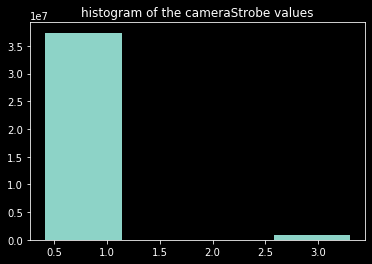

In [8]:
framesStartSample, pupilSmoothArea, motion = \
                    facemapDataReading(cameraStrobe,dataFileBaseFolder,darkMode = darkMode,\
                                                  firstStrobeValid=1)

### stimOnset based on the photoDiode Signal

240 : detected stim onsets from the photodiode sensor


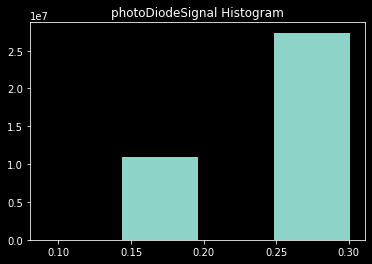

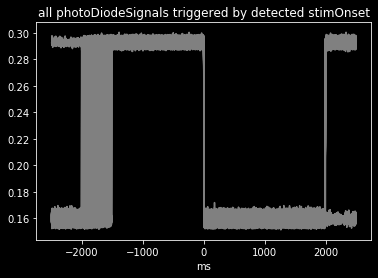

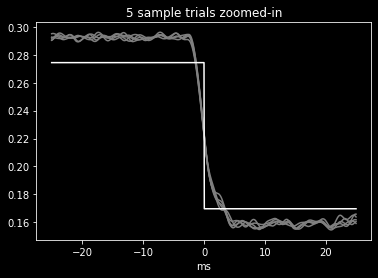

In [19]:
stimOnsetSample = stimOnsetExtraction(photoDiodeSignal,firstBeforeStimTagSampleNo, lastStimTagSampleNo,\
                            stimOnset_DigitalTag_afterStimOnFlip,\
                                      fs)

### extracting the stim offset samples

240 : detected stim offsets from the photodiode sensor


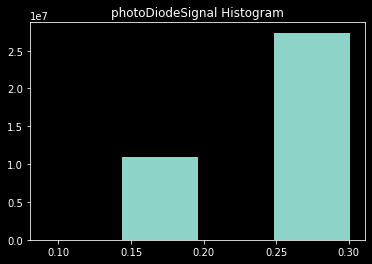

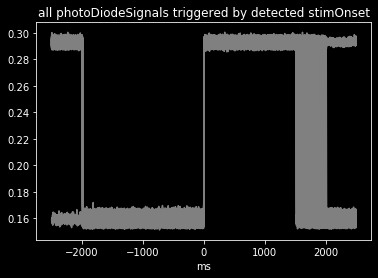

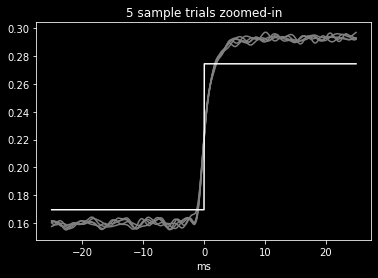

In [20]:
stimOffsetSample = stimOffsetExtraction(photoDiodeSignal,firstBeforeStimTagSampleNo, lastStimTagSampleNo,\
                            stimOnset_DigitalTag_afterStimOnFlip,\
                                      fs)

## loading the sorting results from KiloSort-Phy

#### Ctl+s in Phy first!

In [21]:
spikesSample, spikeClusters, SUA_clusters, MUA_clusters = loadSpikesFromPhy(dataFileBaseFolder)
spikeTime = spikesSample/fs

[ 21  22  33  36  41  47  50  51  58  70  75  76 100 104 116 124 130 131
 133 139 152 153 155 156 157 158 159 160 162 163 164 165 166 167 168 172] these clusters numbers should be the same as the ones that have been asigned as good units in Phy


## Extracting the spike wave-shapes, spont FRs and the channels

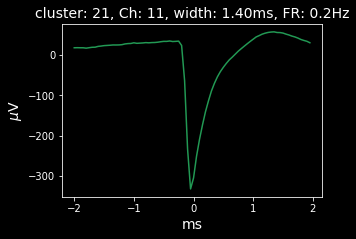

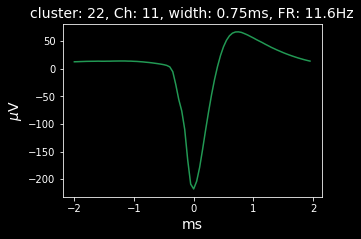

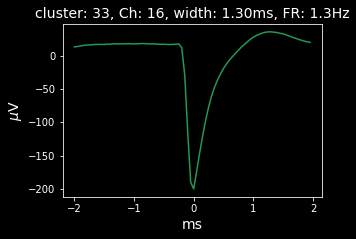

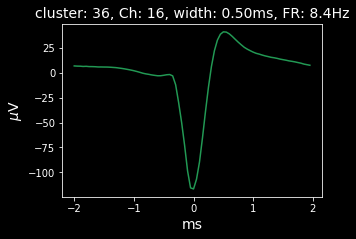

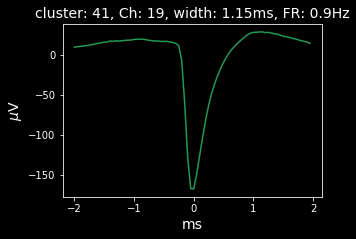

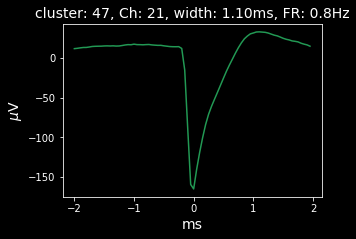

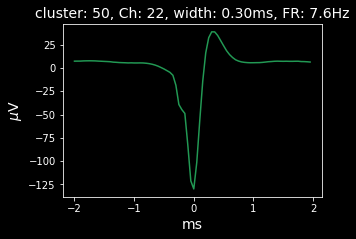

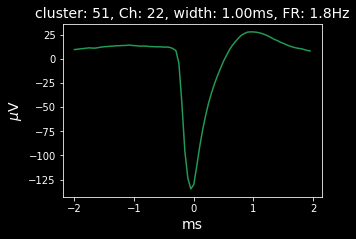

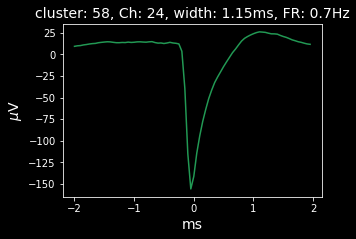

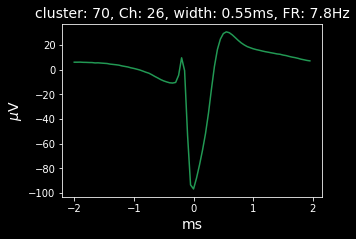

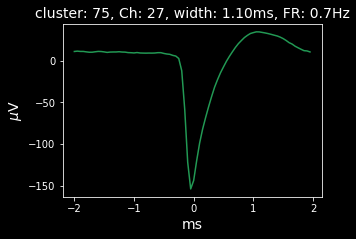

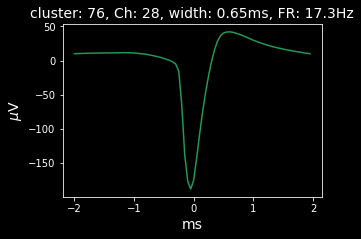

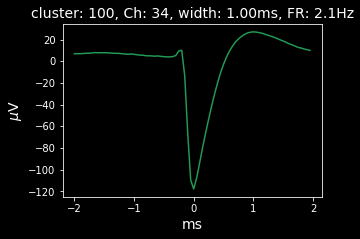

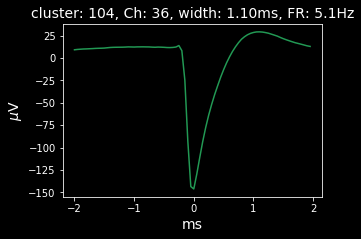

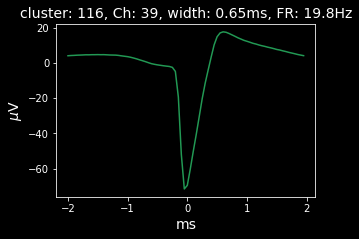

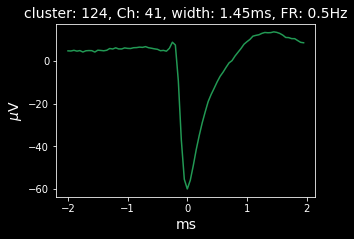

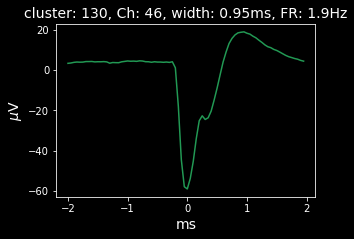

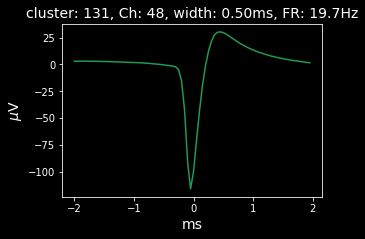

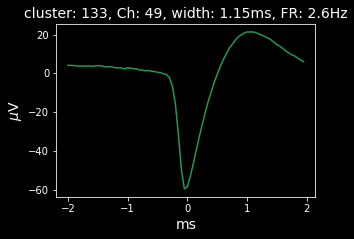

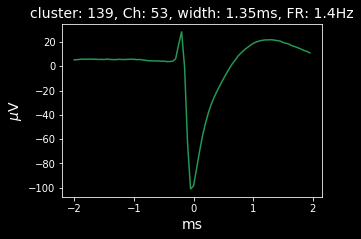

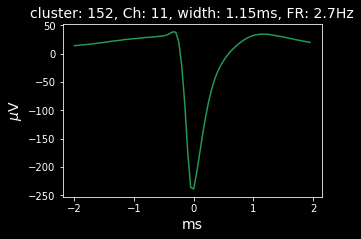

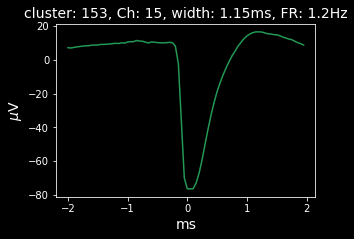

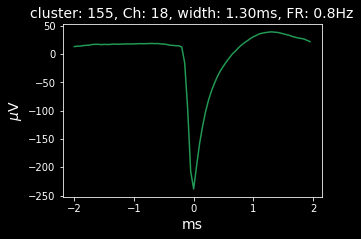

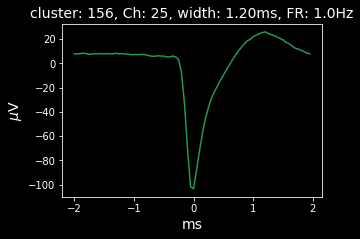

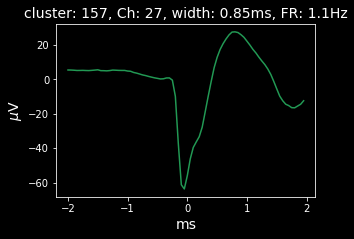

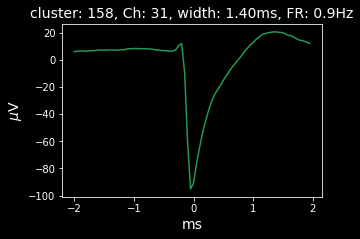

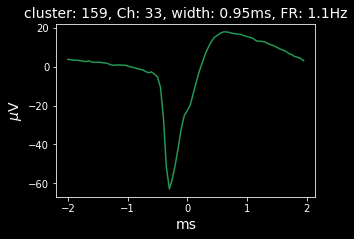

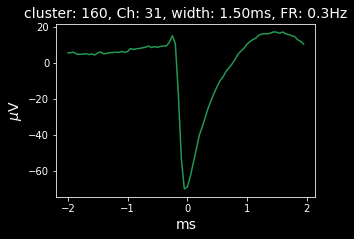

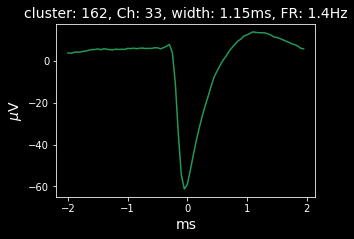

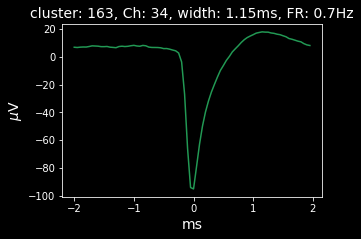

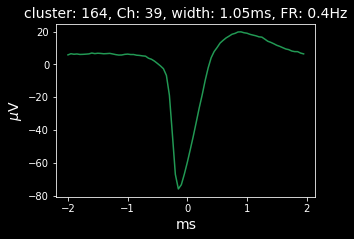

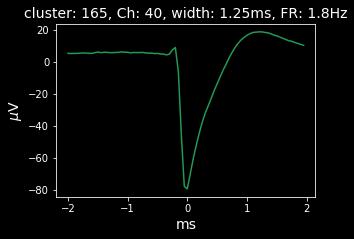

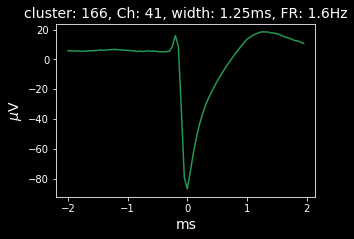

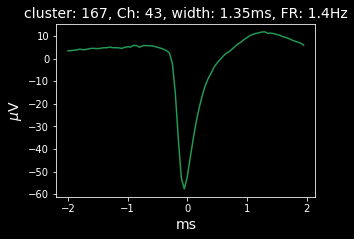

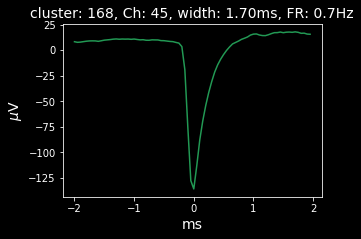

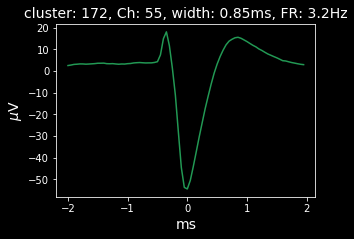

In [22]:
spontFRs, spikeWidthAll, clusterChannel, spikeShapesFiltered, spikeClustersToPlot, recordingDurInMS = \
    neuronsInfoExtraction(dataFileAdd, spikesSample, spikeClusters, SUA_clusters, MUA_clusters,\
                          firstBeforeStimTagSampleNo,\
                          fs, spikeTypes = 'SUA')

### spike-triggered Average of facial motion

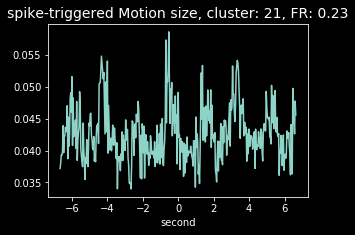

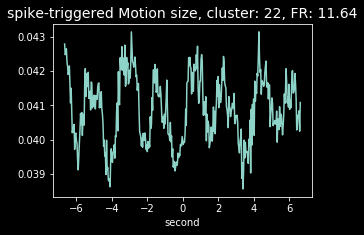

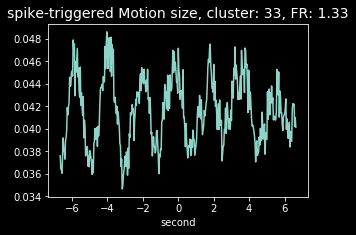

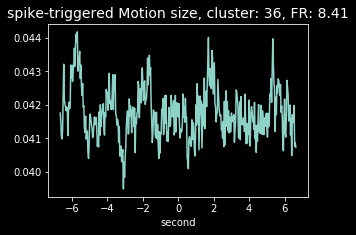

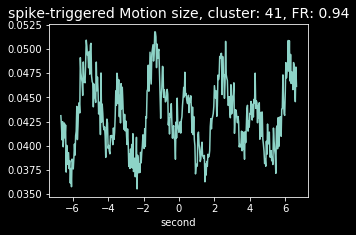

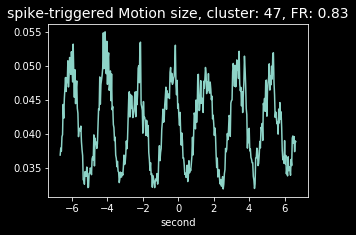

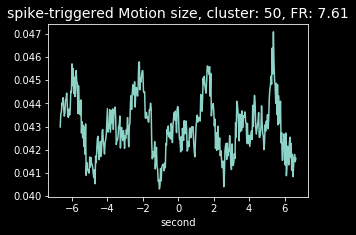

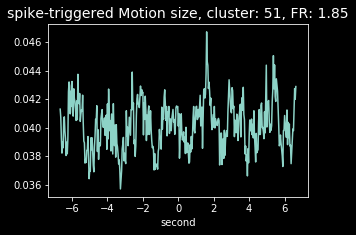

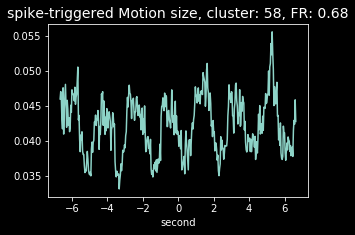

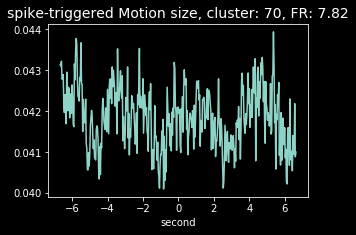

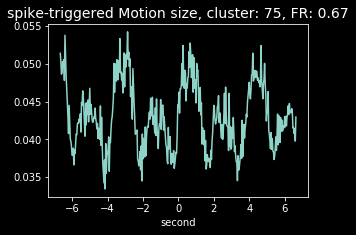

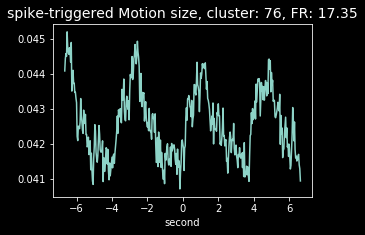

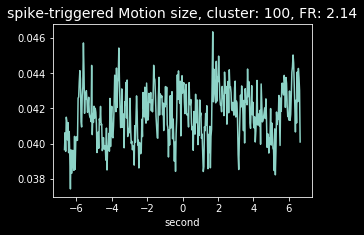

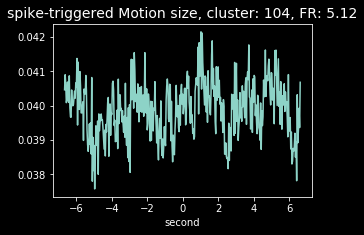

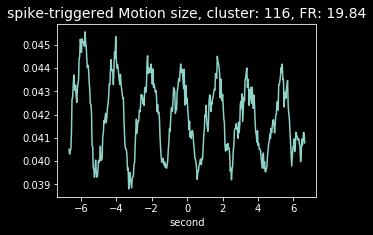

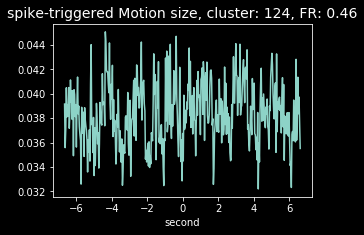

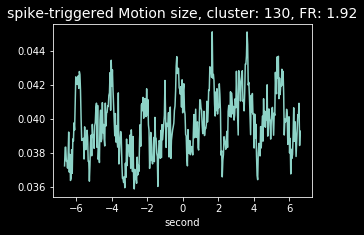

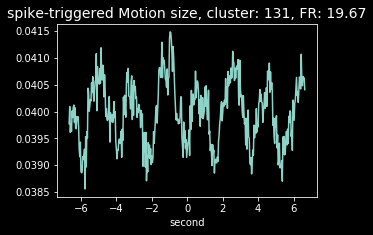

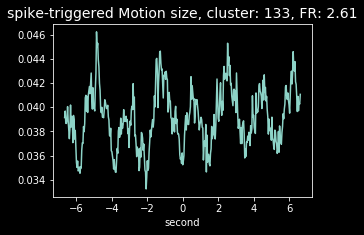

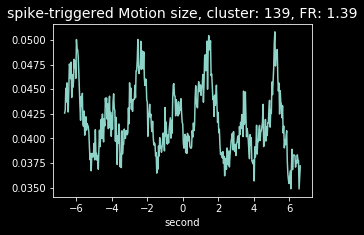

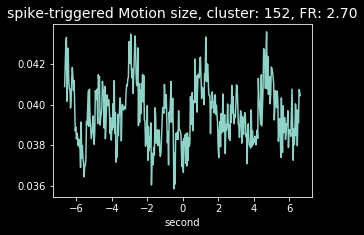

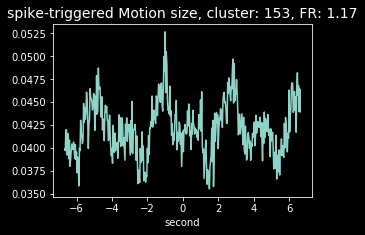

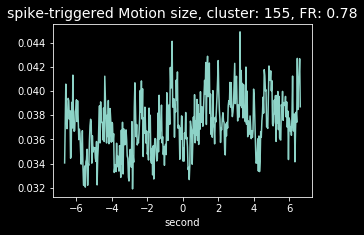

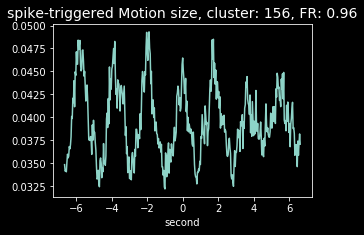

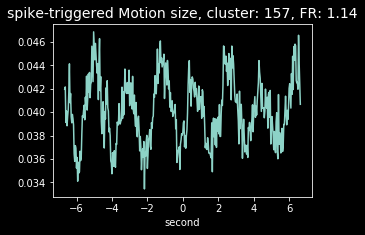

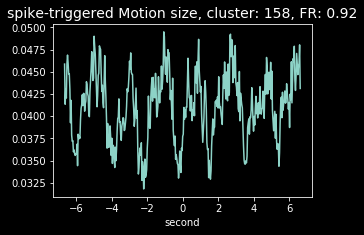

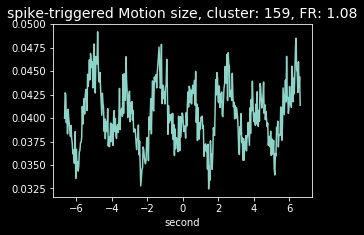

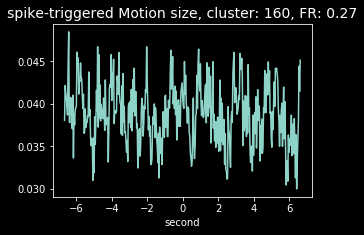

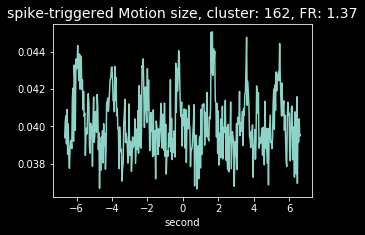

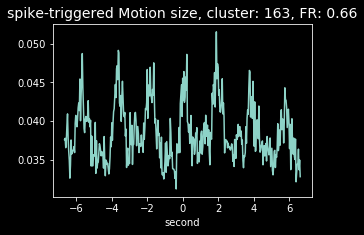

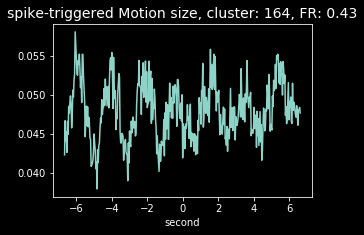

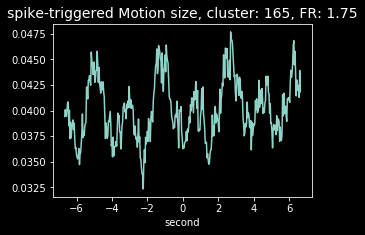

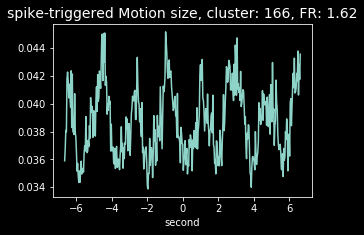

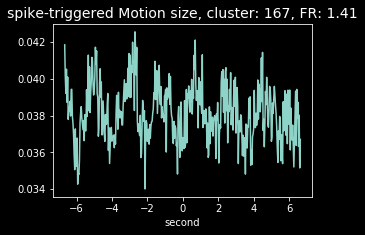

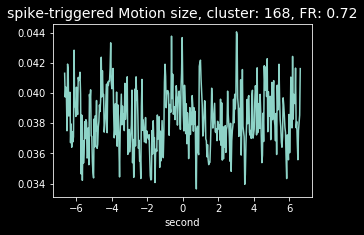

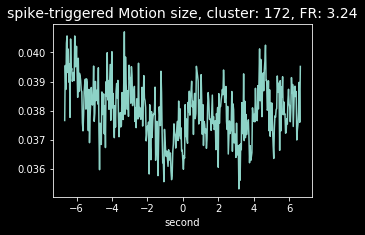

In [23]:
allSpikeTriggeredFacialMovement = spikeTriggeredAvgFacialMovement(framesStartSample,\
                                 motion, spikeClustersToPlot, spikeTime, spikeClusters, spontFRs)

## Facial Movement, Pupil and Alertness

### defining a criteria for alertness based on the distribution of pupil sizes

In [ ]:
# alertness threshold: first estimate the maximum of the pupil area --> 90 percent of the pupil area distribution
# and define the alertness as the half of this value, and check how much time animal has been alert
plt.hist(pupilSmoothArea)
# plt.axvline(0.3*np.max(pupilSmoothArea))
alertnessThreshold = np.percentile(pupilSmoothArea,90)*0.5
plt.axvline(alertnessThreshold)

print('the proportion time that animal has been alert:',\
      len(pupilSmoothArea[pupilSmoothArea>alertnessThreshold])/len(pupilSmoothArea))

### smoothing the motion signal by calculating the average energy across moving windows

In [ ]:
cameraAvgFrameRate = 30

# width of averging window
avgWindowWidth = 1
avgWindowWidthFrameNo = int(avgWindowWidth * cameraAvgFrameRate)

# convolving the motion energy with a rectangular window to get moving average
movingWindowEnergy = np.convolve(motion**2,np.ones(avgWindowWidthFrameNo),'same')/avgWindowWidthFrameNo

# movingWindowEnergy = np.concatenate((np.zeros(int(avgWindowWidthFrameNo/2))\
#                                      ,movingWindowEnergy))[:len(motion)]

# comparing the original motion signal and smoothed motion energy
startTime = 0
endTime = 100
temporalPlot(motion/max(motion),startTime,endTime,30,figuresize=(10,4),lineColor='c')
# plt.figure()
temporalPlot(movingWindowEnergy/max(movingWindowEnergy),startTime,endTime,30,linewidth=4,lineColor='y')

plt.legend(['motion','smoothed energy'])

# plt.figure()
# temporalPlot(pupilSmoothArea/max(pupilSmoothArea),startTime,endTime,30)

### comparing the pupil signal, facial movement and locomotion

In [ ]:
startTime = 0
endTime = 500

temporalPlot(pupilSmoothArea/max(pupilSmoothArea),startTime,endTime,30,figuresize=(10,6),lineColor='grey')


temporalPlot(movingWindowEnergy/max(movingWindowEnergy),startTime,endTime,30)

# plt.figure()


firstCapturedFrame_Sample = framesStartSample[0]

temporalPlot(wheelSensorSignal[firstCapturedFrame_Sample:]/max(wheelSensorSignal),startTime,\
             endTime,fs,lineColor='y')

plt.legend(['pupil area','facial movement','locomotion'])

### visual responsiveness of neurons

In [ ]:
allClustersResponsiveness = []
allClustersBaselineCorrectedResponse = []
allClustersMaxFR_response = []
allClustersFR_responsePattern = []

for clusterNo in spikeClustersToPlot[:]:
    
    # extract the time of spikes for the cluster in this loop iteration
    clusterSpikeTime = spikeTime[np.where(spikeClusters==clusterNo)].squeeze() 
    
    responsiveness, clusterBaselineCorrectedResponse, clusterMaxResponse, clusterResponsivenessPvals,\
    FR_responsePattern, FR_responseTimePoints = \
        neuronVisualResponse(clusterSpikeTime,clusterNo,stimID,stimOnsetSample, \
                             responseWindowEnd = 3000, darkMode = darkMode);
    
    allClustersResponsiveness.append(responsiveness)
    allClustersBaselineCorrectedResponse.append(clusterBaselineCorrectedResponse)
    allClustersMaxFR_response.append(clusterMaxResponse)
    allClustersFR_responsePattern.append(FR_responsePattern)

### Tuning curve and Orienation Selectivity Index

In [ ]:
allOSI = []
# allOSI_max = []
for clusterCounter in range(len(spikeClustersToPlot)):
    if allClustersResponsiveness[clusterCounter]:
        allOSI.append(tuningCurveAndOSI(allClustersBaselineCorrectedResponse[clusterCounter],\
                                       spikeClustersToPlot[clusterCounter]));
#     allOSI_max.append(tuningCurveAndOSI(allClustersMaxFR_response[clusterNo]))

### Baseline and Evoked comparison between alert and non alert trials

In [ ]:
# Extracting the high and low-arousal level trials based on the smoothed facial movement signal
lowArousalStimTrials, highArousalStimTrials = \
            extractLowAndHighArousalTrials(framesStartSample, movingWindowEnergy, stimOnsetSample,\
                timeWindowBeforeStimStart = 0,\
                timeWindowAfterStimStart = 500)

# import random
# lowArousalStimTrials = np.sort(random.sample(range(len(stimID)),int(len(stimID)/2)))
# highArousalStimTrials = np.delete(range(len(stimID)),lowArousalStimTrials)

allTrialsRelResponse, allTrialsBaseline, allTrialsEvokedResponse\
                    = allTrialsResponses(spikeClusters, spikeTime, stimOnsetSample,\
                        spikeClustersToPlot[np.where(allClustersResponsiveness)])

# response change by alertness
allClustersNormalizedArousalResponseChange, allPvalArousalResponseDiff = responseChangeByAlertness(\
            spikeClustersToPlot[np.where(allClustersResponsiveness)],\
            allTrialsRelResponse,highArousalStimTrials,lowArousalStimTrials)

# Basline change by alertness
allClustersNormalizedArousalBaselineChange, allPvalaselineChange = responseChangeByAlertness(\
            spikeClustersToPlot[np.where(allClustersResponsiveness)],\
            allTrialsBaseline,highArousalStimTrials,lowArousalStimTrials,\
            figTitle = 'Baseline Change By Alertness')

# Evoked change by alertness
allClustersNormalizedArousalBaselineChange, allPvalaselineChange = responseChangeByAlertness(\
            spikeClustersToPlot[np.where(allClustersResponsiveness)],\
            allTrialsEvokedResponse,highArousalStimTrials,lowArousalStimTrials,\
            figTitle = 'Evoked-Response Change By Alertness')

# Evoked response change in the preferred stim by alertness
evokedResponseChangeByArousa, pvalEvokedResponseChange = \
bestOrienationResponseChangeByAlertness(spikeClustersToPlot[np.where(allClustersResponsiveness)],\
                                        allTrialsEvokedResponse,\
    highArousalStimTrials,lowArousalStimTrials,allClustersBaselineCorrectedResponse,\
    allClustersResponsiveness,stimID,figTitle = 'Evoked Response Change By Alertness in the Preferred Direction ');

# relative response change in the preferred stim by alertness
bestDirectionRelResponseChangeByArousal, pvalBestDirectionResponseChange = \
bestOrienationResponseChangeByAlertness(spikeClustersToPlot[np.where(allClustersResponsiveness)],\
                                        allTrialsRelResponse,\
    highArousalStimTrials,lowArousalStimTrials,allClustersBaselineCorrectedResponse,\
    allClustersResponsiveness,stimID,figTitle = 'Relative Response Change By Alertness in the Preferred Direction ');

### firing rate pattern change by behavioral state

#### all trials combined

In [ ]:
clusterCounter = 0
for clusterNo in spikeClustersToPlot[:]:
    
    if allClustersResponsiveness[clusterCounter]:
    
        # extract the time of spikes for the cluster in this loop iteration
        clusterSpikeTime = spikeTime[np.where(spikeClusters==clusterNo)].squeeze()

        FR_patternCompareHIghLowArousal(clusterSpikeTime,clusterNo,stimOnsetSample, fs, lowArousalStimTrials, \
                            highArousalStimTrials)
        
    clusterCounter = clusterCounter + 1

#### response to the best orientation

In [ ]:
clusterCounter = 0
for clusterNo in spikeClustersToPlot[:]:#:]:
    
    if allClustersResponsiveness[clusterCounter]:
    
        # extract the time of spikes for the cluster in this loop iteration
        clusterSpikeTime = spikeTime[np.where(spikeClusters==clusterNo)].squeeze()

        bestOrienationFR_patternCompareHighLowArousal(clusterSpikeTime,clusterNo,stimOnsetSample, fs, \
                                            lowArousalStimTrials, highArousalStimTrials,\
                                            allClustersBaselineCorrectedResponse[clusterCounter], stimID)
        
    clusterCounter = clusterCounter + 1

### Tuning Curve and OSI between Alert and non Alert

In [ ]:
allClustersAlertMeanOrientationResponse = []
allClustersNonAlertMeanOrientationResponse = []
OSI_Alert = []
OSI_nonAlert = []
for clusterCounter in range(len(np.where(allClustersResponsiveness)[0])):

    alertMeanOrientationResponse = []
    nonAlertMeanOrientationResponse = []
    for orientationCounter in np.unique(stimID):

        alertResponseCluster = allTrialsRelResponse[clusterCounter]\
                            [np.intersect1d(np.where(stimID==orientationCounter)[0], highArousalStimTrials)]

        nonAlertResponseCluster = allTrialsRelResponse[clusterCounter]\
                            [np.intersect1d(np.where(stimID==orientationCounter)[0], lowArousalStimTrials)]

        alertMeanOrientationResponse.append(np.mean(alertResponseCluster))
        nonAlertMeanOrientationResponse.append(np.mean(nonAlertResponseCluster))
        
    allClustersAlertMeanOrientationResponse.append(alertMeanOrientationResponse)
    allClustersNonAlertMeanOrientationResponse.append(nonAlertMeanOrientationResponse)
#         print(stats.ttest_ind(alertResponseCluster,nonAlertResponseCluster)[1],\
#              np.mean(alertResponseCluster),np.mean(nonAlertResponseCluster))
    
    OSI_Alert.append(tuningCurveAndOSI(alertMeanOrientationResponse,\
                                       spikeClustersToPlot[clusterCounter]))
    OSI_nonAlert.append(tuningCurveAndOSI(nonAlertMeanOrientationResponse,\
                                          spikeClustersToPlot[clusterCounter]))
    
if len(np.where(allClustersResponsiveness)[0]):
    plt.figure()
    plt.plot([1,2],np.array([OSI_Alert,OSI_nonAlert]),'o-')
    plt.xticks([1,2],(['Alert','nonAlert']),fontsize=12)
    plt.title('OSI change with alertness')

### noise correlation between alert and non-alert trials

In [ ]:
noiseCorrAlert, noiseCorrNonAlert, pval = noiseCorrBetweenAlertAndNonAlertTrials\
        (allTrialsRelResponse,highArousalStimTrials,lowArousalStimTrials)

# print(stats.ttest_ind(noiseCorrAlert,noiseCorrNonAlert)[1],np.mean(noiseCorrAlert)\
#               ,np.mean(noiseCorrNonAlert))

### power Spectrum across layers

#### estimated L5 channel

In [ ]:
# the address to the data file (the original reordered or re-referenced recordered)
dataFileAddReorderRereferenced = dataFileBaseFolder + '/' + 'amplifierReorderRereferencedMedian.dat'

# the estimation of L5 based on the power in 500-5000 Hz band
L5channelNo, allChannelsNormHighFreqPower,\
        allChannelsHighFreqPower = estimatedL5chnnael(dataFileAddReorderRereferenced,\
                                                      firstBeforeStimTagSampleNo)

# the estimation of the L4 and L2/3 based on the estimated position for L5
L4channelNo = L5channelNo - 8
L23channelNo = L5channelNo - 15

### reading low pass filtered data file

In [ ]:
dataFile = open(dataFileBaseFolder + '/' + 'amplifierReorderRereferencedLowPass.dat' , 'rb')
dataArray = np.fromfile(dataFile,dtype='int16')
dataFile.close()

del dataFile

dataMatrixReorderLowPassFiltered = np.reshape(dataArray, (int(dataArray.shape[0]/channelsNo), channelsNo)).T

del dataArray

#### power spectrum across layers during spontaneous activity

In [ ]:
# the spontaneous activity is recorded at the begining of the session and the varialbe 
# "firstBeforeStimTagSampleNo" that indicate the first visual stimulus is used to extract the last moment
# of the spontaneous activity

spontEndTime = firstBeforeStimTagSampleNo/fs # in seconds

# the reduced sampling rate used to generated low-pass filtered LFP
reducedSamplingRate = 2e3

# the resolution of power spectrum
df = 0.5

# extracting the spont activity on L5 channel and conversion to microVolts by multiplying to 0.195
inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

# power spectrum L5
f_powerSpectrum, powerSpectrumL5, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L5 - spont' )

print(estimatedTotalPower)

# extracting the spont activity on L4 channel and conversion to microVolts by multiplying to 0.195
inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195
# power spectrum L4
f, powerSpectrumL4, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L4 - spont' )
print(estimatedTotalPower)

# extracting the spont activity on L2/3 channel and conversion to microVolts by multiplying to 0.195
inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195
# power spectrum L2/3
f, powerSpectrumL23, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L2/3 - spont' )
print(estimatedTotalPower)

### defining a criteria for movement

In [ ]:
plt.hist(movingWindowEnergy)

# a fraction of 90% percentile
movementThreshold = np.percentile(movingWindowEnergy,90)*0.25
plt.axvline(movementThreshold)

print('the proportion time that animal has been moving with this criteris: %(number)d%%' %{'number':\
      100*len(movingWindowEnergy[movingWindowEnergy>movementThreshold])/len(movingWindowEnergy)})

startTime = 0
endTime = 1000
temporalPlot(movingWindowEnergy/max(movingWindowEnergy),startTime,endTime,30,figuresize=(15,4))

temporalPlot(movementThreshold*np.ones(len(movingWindowEnergy))/max(movingWindowEnergy),\
             startTime,endTime,30)

plt.legend(['motion smoothed','movement threshold'])


### detecting the consecutive periods of movement

In [ ]:
# This is to extract the epochs of movement and non-movement during spont activity
# movement criteria is set based on the movementThreshold calculated above
# to consider an epoch for movement or non-movement, it should be at least "minimumConsistentStateDur"
# seconds long

minimumConsistentStateDur = 2

alertChoosedEpochsStarts, alertChoosedEpochsEnds, nonAlertChoosedEpochsStarts, \
    nonAlertChoosedEpochsEnds = exctractAlertAndNonAlertPeriods(movingWindowEnergy,framesStartSample,\
                0,spontEndTime, minimumConsistentStateDur = minimumConsistentStateDur,\
                alertnessThreshold = movementThreshold)

#### checking the LFP around the time of movement start

In [ ]:
from scipy.signal import hilbert

windowToShow = 20
reducedSamplingRate = 2e3

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]

# lowFreqBand = 1
highFreqBand = 150
inputSignalToFreqAnalysis = butter_lowpass_filter(inputSignalToFreqAnalysis,\
                                highFreqBand,reducedSamplingRate)

hilbertTransformedSig = hilbert(inputSignalToFreqAnalysis)
ampTransformedSig = np.abs(hilbertTransformedSig)

for alertMovementEpochCounter in range(len(alertChoosedEpochsStarts)):
    
    movementTime = framesStartSample[alertChoosedEpochsStarts[alertMovementEpochCounter]]/fs
#     epochEndTime = framesStartSample[alertChoosedEpochsEnds[alertMovementEpochCounter]]/fs
    
    epochStartTime = movementTime - windowToShow/2
    epochEndTime = movementTime + windowToShow/2
    
#     plt.figure()
#     temporalPlot(inputSignalToFreqAnalysis,epochStartTime,epochEndTime,reducedSamplingRate,\
#                 figuresize=(20,4),figNo=alertMovementEpochCounter)
    temporalPlot(ampTransformedSig,epochStartTime,epochEndTime,reducedSamplingRate,\
                figuresize=(20,4),figNo=alertMovementEpochCounter)
    plt.axvline(movementTime)

### power spectrum between movement and non-movement periods

In [ ]:
timToExclude = 0 

df = 2 #in Hz; spectrum resolution

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]
f_spectrumL5, motionSpectrumL5Abs, stillnessSpectrumL5Abs, motionTotalPowerL5, stillnessTotalPowerL5\
            = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
        alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = timToExclude, df = df, figTitle = 'Spectrum L5')

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]
f_spectrumL4, motionSpectrumL4Abs, stillnessSpectrumL4Abs, motionTotalPowerL4, stillnessTotalPowerL4\
            = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
        alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = timToExclude, df = df, figTitle = 'Spectrum L4')

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]
f_spectrumL23, motionSpectrumL23Abs, stillnessSpectrumL23Abs, motionTotalPowerL23, stillnessTotalPowerL23\
            = spectrumCompareAlertNonAlert (inputSignalToFreqAnalysis,\
        alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = timToExclude, df = df, figTitle = 'Spectrum L2/3')

### compare the bands between motion and stillness

#### Total  gamma Power

In [ ]:
lowBand = 30
highBand = 70

motionStillnessPowerCompare(motionSpectrumL5Abs, stillnessSpectrumL5Abs, lowBand, highBand,\
                                df, figTitle='Total gamma power')

#### Total 0-10 Hz Power

In [ ]:
lowBand = 0
highBand = 10

motionStillnessPowerCompare(motionSpectrumL5Abs, stillnessSpectrumL5Abs, lowBand, highBand,\
                                df, figTitle='Total 0-10Hz power')

#### Relative gamma power

In [ ]:
lowBand = 30
highBand = 70

relativeMotionPower = np.array([motionSpectrumL5Abs[epochCounter]/motionTotalPowerL5[epochCounter]\
                              for epochCounter in range(len(motionSpectrumL5Abs))])

relativeStillnessPower = np.array([stillnessSpectrumL5Abs[epochCounter]/stillnessTotalPowerL5[epochCounter]\
                              for epochCounter in range(len(stillnessSpectrumL5Abs))])

motionStillnessPowerCompare(relativeMotionPower,\
                            relativeStillnessPower, lowBand, highBand,\
                                df, figTitle='Rel gamma power',relPower=1)

#### Relative 0-10Hz power

In [ ]:
lowBand = 0
highBand = 10

relativeMotionPower = np.array([motionSpectrumL5Abs[epochCounter]/motionTotalPowerL5[epochCounter]\
                              for epochCounter in range(len(motionSpectrumL5Abs))])

relativeStillnessPower = np.array([stillnessSpectrumL5Abs[epochCounter]/stillnessTotalPowerL5[epochCounter]\
                              for epochCounter in range(len(stillnessSpectrumL5Abs))])

motionStillnessPowerCompare(relativeMotionPower,\
                            relativeStillnessPower, lowBand, highBand,\
                                df, figTitle='Rel 0-10Hz power',relPower=1)

#### gamma power relative to the power in 0-10Hz

In [ ]:
motionStillnessPowerCompareGammaAndLowFreq(motionSpectrumL5Abs, stillnessSpectrumL5Abs\
                                           ,df,figTitle='gamma/(0-10Hz)')

#### changes in spont FR with facial movement

In [ ]:
motionSpontFR, stillnessSpontFR, motionSpontDur, stillnessSpontDur = \
spontFR_CompareAlertAndNonAlert(spikesSample, spikeClusters, spikeClustersToPlot,\
     alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = 0)

plt.figure()
plt.plot([1,2],np.array([motionSpontFR,stillnessSpontFR]),'o-',c='grey')
plt.xticks([1,2],(['Motion','Stillness']),fontsize=12)
plt.title('FR change with facial movement')
plt.ylabel('firing rate (Hz)')

In [ ]:
stateFR_changeIndex = (motionSpontFR - stillnessSpontFR)/(motionSpontFR + stillnessSpontFR)
pvalFRStateChange = stats.ttest_1samp(stateFR_changeIndex,0)[1]
plt.hist(stateFR_changeIndex)
plt.title('FR change index')
plt.text(0.25,0.8,'p=%(number)0.3f'%{'number':pvalFRStateChange})


### spike-triggering firing pattern during the spon activity

In [ ]:
# start and end of the part that is used to calculate the relative spiking of the pair of neurons
sessionStart = 0
sessionEnd = spontEndTime

peakCrossCorrsAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
delaySpikingAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
triggeredSpikeTimesAllPairs = []
smoothedCrossCorrsAllPairs = []
ks_PvalAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])

# getting the crosscorr pattern for all pair of neurons (calculation on haf of pairs: when the order of 
# neurons changes the peak value is the same and the delay is reversed relative to zero)
for clusterCounter1 in range(len(spikeClustersToPlot)-1):
    for clusterCounter2 in range(clusterCounter1+1,len(spikeClustersToPlot)):
        clusterNo1 = spikeClustersToPlot[clusterCounter1]
        clusterNo2 = spikeClustersToPlot[clusterCounter2]

        # extract the spike time of the two neurons
        spikeTimesNeuron1 = spikeTime[np.where(spikeClusters==clusterNo1)].squeeze()*1e3
        spikeTimesNeuron2 = spikeTime[np.where(spikeClusters==clusterNo2)].squeeze()*1e3
        
        plt.figure()
        
        triggeredSpikeTimes, smoothedCrossCorr, peakCrossCorrsAllPairs[clusterCounter1][clusterCounter2], \
                    delaySpikingAllPairs[clusterCounter1][clusterCounter2],\
                    ks_PvalAllPairs[clusterCounter1][clusterCounter2] = \
                        spikeTriggeredFR(spikeTimesNeuron1,spikeTimesNeuron2,sessionStart,sessionEnd,\
                            preWindowLen = 100,postWindowLen = 100,figureShow=1)
        
        plt.title('CrossCorr Pattern Cluster %(number1)d and Cluster %(number2)d' \
                  %{'number1':clusterNo1,'number2':clusterNo2})

        peakCrossCorrsAllPairs[clusterCounter2][clusterCounter1] = \
                            peakCrossCorrsAllPairs[clusterCounter1][clusterCounter2]
        
        ks_PvalAllPairs[clusterCounter2][clusterCounter1] = \
                            ks_PvalAllPairs[clusterCounter1][clusterCounter2]
        
        delaySpikingAllPairs[clusterCounter2][clusterCounter1] = \
                            delaySpikingAllPairs[clusterCounter1][clusterCounter2]
        
        triggeredSpikeTimesAllPairs.append(triggeredSpikeTimes)
        smoothedCrossCorrsAllPairs.append(smoothedCrossCorr)

#### cross corrs movement vs stillness

In [ ]:
peakCrossCorrsAlertAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
delaySpikingAlertAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
ks_Pval_AlertAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
triggeredSpikeTimesAlertAllPairs = []
smoothedCrossCorrsAlertAllPairs = []

peakCrossCorrsNonAlertAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
delaySpikingNonAlertAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
ks_Pval_NonAlertAllPairs = np.zeros([len(spikeClustersToPlot),len(spikeClustersToPlot)])
triggeredSpikeTimesNonAlertAllPairs = []
smoothedCrossCorrsNonAlertAllPairs = []

for clusterCounter1 in range(len(spikeClustersToPlot)-1):
    for clusterCounter2 in range(clusterCounter1+1,len(spikeClustersToPlot)):
        clusterNo1 = spikeClustersToPlot[clusterCounter1]
        clusterNo2 = spikeClustersToPlot[clusterCounter2]

        # extract the spike time of the two neurons
        spikeTimesNeuron1 = spikeTime[np.where(spikeClusters==clusterNo1)].squeeze()*1e3
        spikeTimesNeuron2 = spikeTime[np.where(spikeClusters==clusterNo2)].squeeze()*1e3
        
        plt.figure()
        
        alertTriggeredSpikes, nonAlertTriggeredSpikes, \
        smoothedCrossCorrAlert, smoothedCrossCorrNonAlert, \
        peakCrossCorrsAlertAllPairs[clusterCounter1][clusterCounter2], \
        peakCrossCorrsNonAlertAllPairs[clusterCounter1][clusterCounter2], \
        delaySpikingAlertAllPairs[clusterCounter1][clusterCounter2], \
        delaySpikingNonAlertAllPairs[clusterCounter1][clusterCounter2], \
        ks_Pval_AlertAllPairs[clusterCounter1][clusterCounter2], \
        ks_Pval_NonAlertAllPairs[clusterCounter1][clusterCounter2] = \
                            spikeTriggeredFR_alertNonAlert(spikeTimesNeuron1,spikeTimesNeuron2,\
                            alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
                            nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
                            preWindowLen = 100,postWindowLen = 100, timeToExclude = 0, fs = fs,\
                                figureShow =0)
        
        plt.title('CrossCorr Pattern Cluster %(number1)d and Cluster %(number2)d' \
                  %{'number1':clusterNo1,'number2':clusterNo2})
        
        
        peakCrossCorrsAlertAllPairs[clusterCounter2][clusterCounter1] = \
                                peakCrossCorrsAlertAllPairs[clusterCounter1][clusterCounter2]
        
        peakCrossCorrsNonAlertAllPairs[clusterCounter2][clusterCounter1] = \
                                peakCrossCorrsNonAlertAllPairs[clusterCounter1][clusterCounter2]
        
        delaySpikingAlertAllPairs[clusterCounter2][clusterCounter1] = \
                                delaySpikingAlertAllPairs[clusterCounter1][clusterCounter2]
        
        delaySpikingNonAlertAllPairs[clusterCounter2][clusterCounter1] = \
                                delaySpikingNonAlertAllPairs[clusterCounter1][clusterCounter2]
        
        ks_Pval_NonAlertAllPairs[clusterCounter2][clusterCounter1] = \
                                ks_Pval_NonAlertAllPairs[clusterCounter1][clusterCounter2]
        
        ks_Pval_AlertAllPairs[clusterCounter2][clusterCounter1] = \
                                ks_Pval_AlertAllPairs[clusterCounter1][clusterCounter2]
        
        triggeredSpikeTimesAlertAllPairs.append(alertTriggeredSpikes)
        triggeredSpikeTimesNonAlertAllPairs.append(nonAlertTriggeredSpikes)
        
        smoothedCrossCorrsAlertAllPairs.append(smoothedCrossCorrAlert)
        smoothedCrossCorrsNonAlertAllPairs.append(smoothedCrossCorrNonAlert)

#         peakCrossCorrsAllPairs[clusterCounter2][clusterCounter1] = \
#                             peakCrossCorrsAllPairs[clusterCounter1][clusterCounter2]
        
#         delaySpikingAllPairs[clusterCounter2][clusterCounter1] = \
#                             delaySpikingAllPairs[clusterCounter1][clusterCounter2]

### variables to save

In [ ]:
# 0 waveshapes
# 1 spikeWidth
# 2 spont FRs
# 3 clusterChannel
# 4 spike-triggered pupil area
# 5 responsiveness 
# 6 baselineCorrectedResponse
# 7 OSI
# 8 Alert OSI
# 9 nonAlert OSI
# 10 relative response Change By Arousal
# 11 basline change by arousal
# 12 evoked-response change by arousal
# 13 best direction response change by arousal
# 14 noise correlation alert
# 15 noise correlation non-alert
# 16 normalized high freq power on all channels
# 17 high freq power on all channels
# 18 power sepctrum L5
# 19 power spectrum L4
# 20 power spectrum L23
# 21 frequency vector
# 22 power spectrum alert L5
# 23 power spectrum non alert L5
# 24 power spectrum alert L4
# 25 power spectrum non alert L4
# 26 power spectrum alert L23
# 27 power spectrum non alert L23
# 28 alert spont FR (facial movement periods)
# 29 non-alert spont FR (based on the facial movement)
# 30 L5 estimated channel
# 31 vectors of triggered spike times (all pairs of neurons)
# 32 matrix of the peak values of the smoothed cross correlograms for all pairs (distance of conditioned PDF from chance level)
# 33 matrix of delay of cross-correlograms for all pairs (argmax of the conditioned PDF)
# 34 smoothed cross-corrs for all pairs
# 35 triggered spike times during alert periods for all pairs (facial movement for the alertness)
# 36 peak of cross corrs during alertness
# 37 delay of cross corres for alert periods for all pairs
# 38 smoothed cross-corrs for alert periods for all pairs
# 39 triggered spike times during non-alert periods for all pairs (facial movement for the alertness)
# 40 peak of cross corrs during non-alertness
# 41 delay of cross corres for non-alert periods for all pairs
# 42 smoothed cross-corrs for non-alert periods for all pairs
# 43 ks-test pvalue for all pairs (cross-corr patterns against the uniform distribution)
# 44 spike-triggered facial movement
# 45 ks-test pvalue for all pairs during alert period
# 46 ks-test pvalue for all pairs during nonAlert period

animalName = dataFileBaseFolder[len(dataFileBaseFolder) - dataFileBaseFolder[::-1].find('/'):\
                   len(dataFileBaseFolder) - 13]

savingAdd = 'Y://Ehsan-temp//Claire-Ehsan_Share//DataToMerge//'

variableToExportToMerge = [spikeShapesFiltered, spikeWidthAll, spontFRs, clusterChannel,\
        allSpikeTriggeredPupil, allClustersResponsiveness, \
        allClustersBaselineCorrectedResponse, allOSI, OSI_Alert, OSI_nonAlert,\
        allClustersNormalizedArousalResponseChange, allClustersNormalizedArousalBaselineChange,\
        evokedResponseChangeByArousa, bestDirectionRelResponseChangeByArousal, noiseCorrAlert, \
        noiseCorrNonAlert, allChannelsNormHighFreqPower, allChannelsHighFreqPower, powerSpectrumL5,\
        powerSpectrumL4, powerSpectrumL23, f_powerSpectrum, motionSpectrumL5Abs, stillnessSpectrumL5Abs,\
        motionSpectrumL4Abs, stillnessSpectrumL4Abs, motionSpectrumL23Abs, stillnessSpectrumL23Abs,\
        motionSpontFR, stillnessSpontFR, L5channelNo, triggeredSpikeTimesAllPairs, peakCrossCorrsAllPairs,\
        delaySpikingAllPairs, smoothedCrossCorrsAllPairs, triggeredSpikeTimesAlertAllPairs, \
        peakCrossCorrsAlertAllPairs, delaySpikingAlertAllPairs, smoothedCrossCorrsAlertAllPairs,\
        triggeredSpikeTimesNonAlertAllPairs, peakCrossCorrsNonAlertAllPairs, delaySpikingNonAlertAllPairs,\
        smoothedCrossCorrsNonAlertAllPairs, ks_PvalAllPairs, allSpikeTriggeredFacialMovement,\
        ks_Pval_AlertAllPairs,ks_Pval_NonAlertAllPairs]

import pickle
pickle.dump(variableToExportToMerge, open(savingAdd+animalName+'.pkl', "wb" ) )

In [ ]:
import scipy.io

In [ ]:
io.savemat('test.mat',{'i':i,'m':m,'rule':rule})

In [ ]:
cameraDataValid = True

if not(cameraDataValid):
    allOSI = []
    OSI_Alert = []
    OSI_nonAlert = []
    allClustersNormalizedArousalResponseChange = []
    allClustersNormalizedArousalBaselineChange = []
    evokedResponseChangeByArousa = []
    bestDirectionRelResponseChangeByArousal = []
    noiseCorrAlert = []
    noiseCorrNonAlert = []
    motionSpectrumL5Abs = []
    stillnessSpectrumL5Abs = []
    motionSpectrumL4Abs = []
    stillnessSpectrumL4Abs = []
    motionSpectrumL23Abs = []
    stillnessSpectrumL23Abs = []
    motionSpontFR = []
    stillnessSpontFR = []
    triggeredSpikeTimesAlertAllPairs = []
    peakCrossCorrsAlertAllPairs = []
    delaySpikingAlertAllPairs = []
    smoothedCrossCorrsAlertAllPairs = []
    triggeredSpikeTimesNonAlertAllPairs = []
    peakCrossCorrsNonAlertAllPairs = []
    delaySpikingNonAlertAllPairs = []
    smoothedCrossCorrsNonAlertAllPairs = []
    allSpikeTriggeredFacialMovement = []